In [1]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import wave
import time
import librosa

from pyannote.audio.pipelines import VoiceActivityDetection

from boto3 import Session

The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.
torchvision is not available - cannot save figures
The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.


In [6]:
config_json = open("../LableniBotConfig/config.json")
config_dict = json.load(config_json)

with open('Results/NoDepressSubjects.txt', 'r') as f:
    subj_no_depress_list = f.readlines()
subj_no_depress_list = [subj.replace("\n", "") for subj in subj_no_depress_list]

In [7]:
config_json = open("../LableniBotConfig/config.json")
config_dict = json.load(config_json)

hugging_face_key = config_dict["HUGGING_FACE"]

silence_detection_pipeline = VoiceActivityDetection(segmentation="pyannote/segmentation",
                                                    use_auth_token=hugging_face_key)

In [8]:
session = Session(
    aws_access_key_id=config_dict["AWS_ACCESS_KEY_ID"],
    aws_secret_access_key=config_dict["AWS_SECRET_ACCESS_KEY"]
)
polly = session.client("polly", region_name='eu-west-1')

In [9]:
def from_str_to_aws_polly_pcm(input_str, aws_prosody="slow"):
    input_str_aws = input_str
    input_str_aws = input_str_aws.replace("?", ".").replace("¿", ".")
    input_str_aws = input_str_aws.replace('.', '<break time="0.6s"/>')
    input_str_aws = input_str_aws.replace(',', '<break time="0.25s"/>')
    input_str_aws = '<prosody rate="' + aws_prosody + '">' + input_str_aws + '</prosody>'
    input_str_aws = "<speak>" + input_str_aws + "</speak>"

    return input_str_aws

In [38]:
os.listdir("../Conversations/" + subj + "_Conversations/")[2:]

['User_01_CB_20221116_094233',
 'User_01_CB_20221116_094932',
 'User_01_CB_20221116_095440',
 'User_01_CB_20221116_095834',
 'User_01_CB_20221116_100351',
 'User_01_CB_20221116_100942',
 'User_01_CB_20221116_101436']

In [48]:
for subj in subj_no_depress_list:
    
    print("Subject", subj, end="\r")
    
    path_to_folders = "../Conversations/" + subj + "_Conversations/"
    try:
        all_folders_inside = os.listdir(path_to_folders)[2:]
    except:
        print("Bad subject", path_to_folders)
        continue
    
    for folder in all_folders_inside:
        path_to_conv = path_to_folders + folder + "/"
        conv_f_name = os.listdir(path_to_conv)[2]
        try:
            df_conv = pd.read_csv(path_to_conv + conv_f_name, sep=";")
        except:
            print("Bad subject", path_to_conv + conv_f_name)
            continue
        
        vh_personality, vh_gender, vh_id = df_conv["ConfigName"].iloc[0].split("_")
        
        vh_voice_id = "Lucia" if vh_gender == "Female" or vh_gender == "Woman" else "Enrique"
        vh_engine = "neural" if vh_voice_id == "Lucia" else "standard"
        
        for i_b_m, bot_message in enumerate(df_conv[df_conv["Source"] == "Bot"]["SpanishMessage"].values):
            
            audio_name = subj + "_" + vh_personality + "_"+ vh_gender + "_" + vh_id + "_Mssg" + str(i_b_m)
            root_bot_audio = "../VHAudios/AllAudios/" + audio_name + ".mp3"
            
            if audio_name + ".mp3" in os.listdir("../VHAudios/AllAudios/"):
                continue
            
            bot_message_spanish_aws = from_str_to_aws_polly_pcm(bot_message)
            
            response = polly.synthesize_speech(
                Text=bot_message_spanish_aws,
                OutputFormat="pcm",
                VoiceId=vh_voice_id,
                # SampleRate=str(RATE),
                Engine=vh_engine,
                TextType="ssml"
            )
            
            OMNI_CHANNELS = 1  # Polly's output is a mono audio stream
            WAV_SAMPLE_WIDTH_BYTES = 2  # Polly's output is a stream of 16-bits (2 bytes) samples
            RATE_AWS = 16000
            FRAMES = []

            # Processing the response to audio stream
            STREAM = response.get("AudioStream")
            FRAMES.append(STREAM.read())
            # TODO: Save these audios as the subjects audios are saved.

            WAVE_FORMAT = wave.open(root_bot_audio, 'wb')
            WAVE_FORMAT.setnchannels(OMNI_CHANNELS)
            WAVE_FORMAT.setsampwidth(WAV_SAMPLE_WIDTH_BYTES)
            WAVE_FORMAT.setframerate(RATE_AWS)
            WAVE_FORMAT.writeframes(b''.join(FRAMES))
            WAVE_FORMAT.close()
            
print()  
print("End")        

Bad subject ../Conversations/USER_48_CB2_Conversations/
Bad subject ../Conversations/USER_47_CB2_Conversations/
Bad subject ../Conversations/USER_38_CB2_Conversations/USER_38_CB2_20230223_093627/Conv_20230223_093627.pkl
Bad subject ../Conversations/User_50_CB_Conversations/User_50_CB_20221219_144734/Conv_20221219_144734.pkl
Subject User_01_CB
End


In [20]:
result_audio_list = []
for i_conv, all_conv in enumerate(os.listdir("../VHAudios/AllAudios/")):
    
    print("Iteration", i_conv, end="\r")
    
    audio_split = all_conv.split("_")
    
    user_id = "_".join(audio_split[:3])
    user_id = user_id.replace("User", "USER")
    audio_id = int(audio_split[-1].split(".")[0].replace("Mssg", ""))
    
    whole_audio_path = "../VHAudios/AllAudios/" + all_conv

    audio_duration = librosa.get_duration(filename=whole_audio_path)

    vad = silence_detection_pipeline(whole_audio_path)
    segments_timeline = list(vad.get_timeline().segments_set_)

    first_start = np.min([seg.start for seg in segments_timeline])
    last_end = np.max([seg.end for seg in segments_timeline])
    num_talk_stops = len(segments_timeline)-1

    time_waste_silence = audio_duration - last_end
    time_talking = last_end - first_start
    perc_talking_audio = 100 * time_talking/audio_duration

    result_audio_list.append({
        "AudioPosition": audio_id,
        "VHID": audio_split[4],
        "SubjectId": user_id,
        "Personality": audio_split[3],
        "AudioDuration": audio_duration,
        "FirstStart": first_start,
        "LastEnd": last_end,
        "NumTalks": num_talk_stops,
        "TimeWasteSilence": time_waste_silence,
        "TimeTalking": time_talking,
        "PercTalkingAudio": perc_talking_audio,
        "AudioPath": all_conv
    })


In [21]:
df_vh_audio = pd.DataFrame(result_audio_list)

In [23]:
df_vh_audio.to_csv("Results/AudioVHProcessed.csv", sep=";", index=False)

In [2]:
raw = wave.open("../VHAudios/AllAudios/USER_02_CB2_Sad_2_Mssg5.mp3")
signal = raw.readframes(-1)
signal = np.frombuffer(signal, dtype ="int16")
f_rate = raw.getframerate()
time = np.linspace(0, len(signal) / f_rate, num = len(signal))

53180

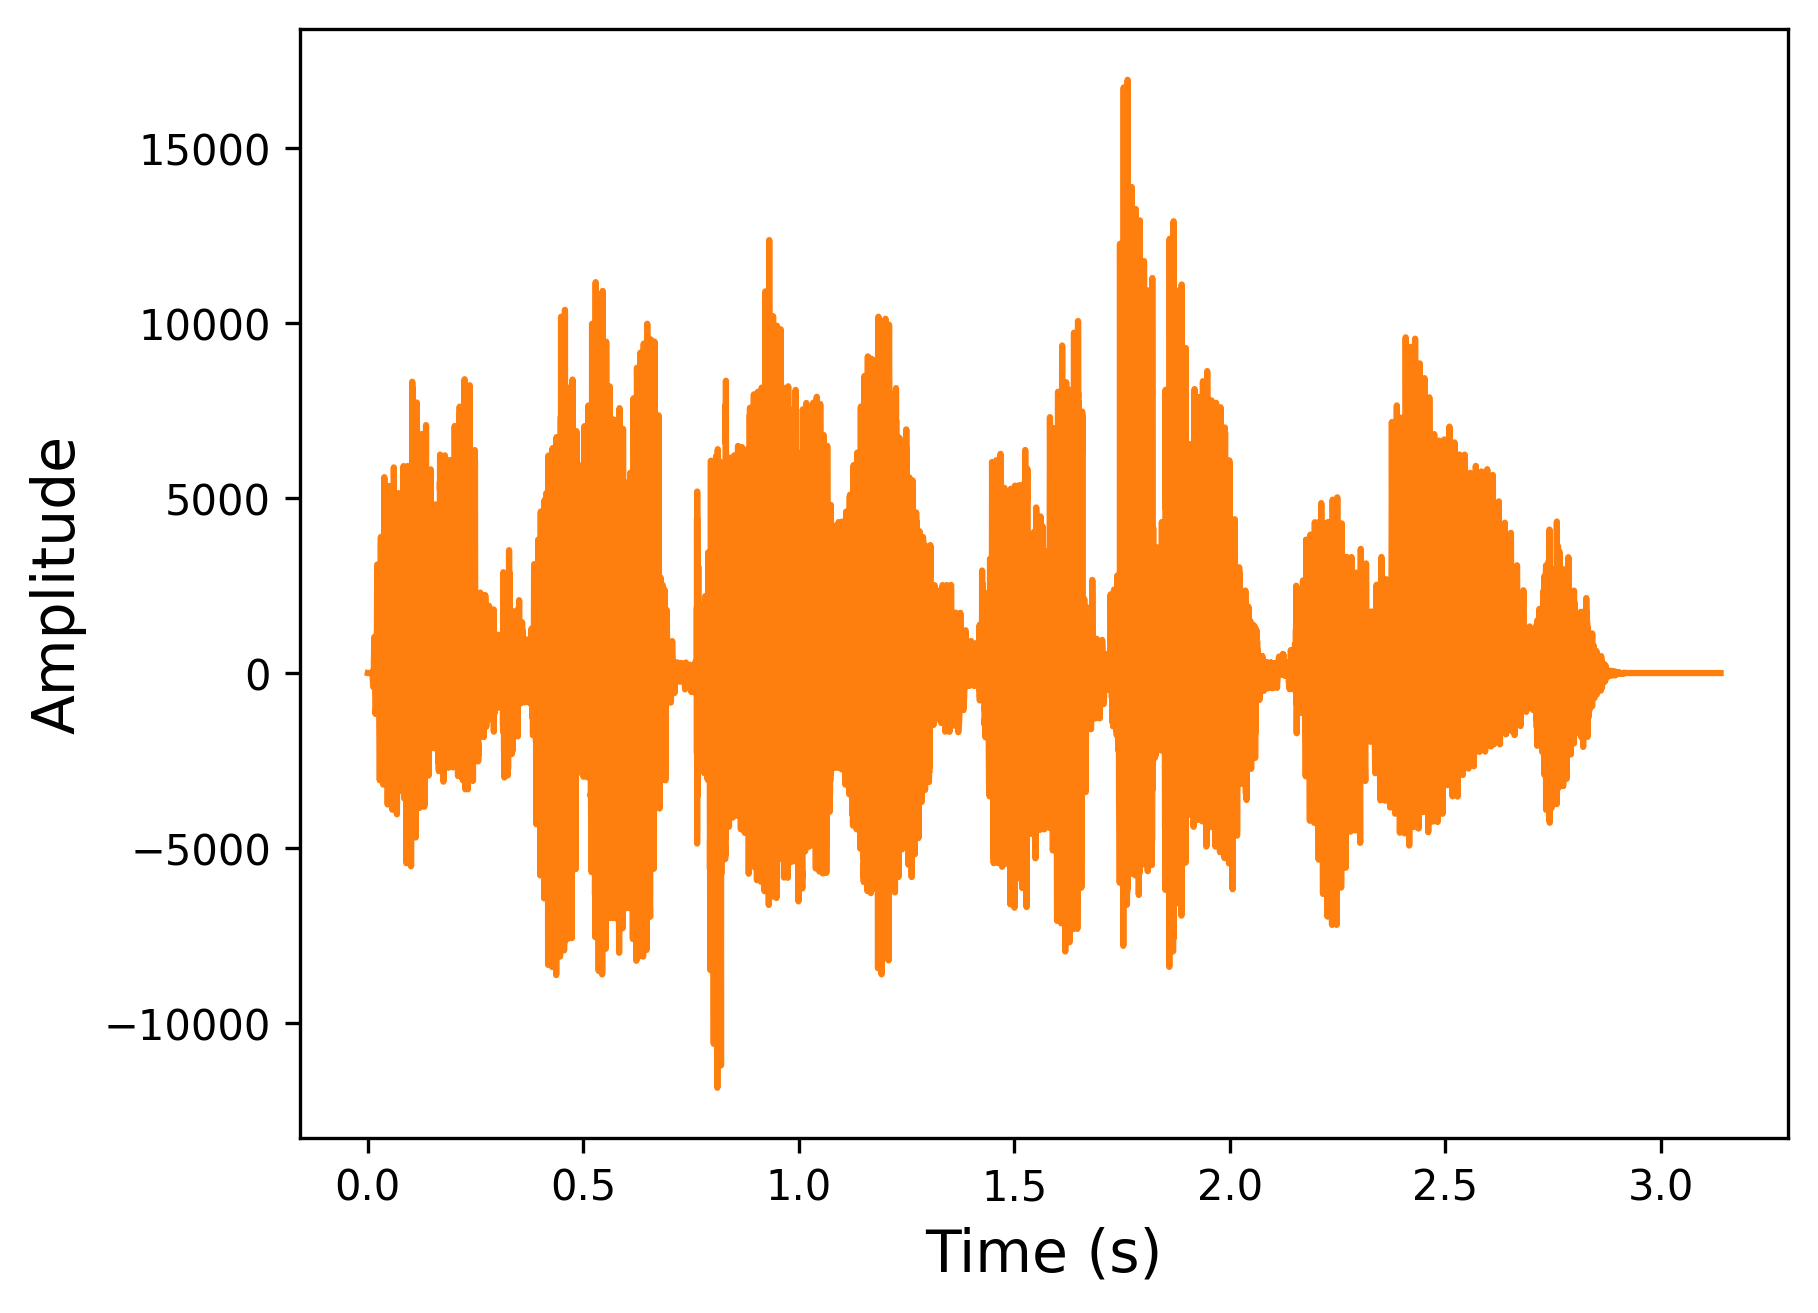

In [11]:
plt.figure(dpi=300)

# actual plotting
plt.plot(time[:int(0.85*len(signal))], signal[:int(0.85*len(signal))], c="tab:orange")
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Amplitude", fontsize=14)

plt.savefig("Results/VHAUDIO.pdf", dpi=300, format="pdf", bbox_inches='tight')

# shows the plot
# in new window
# plt.show()

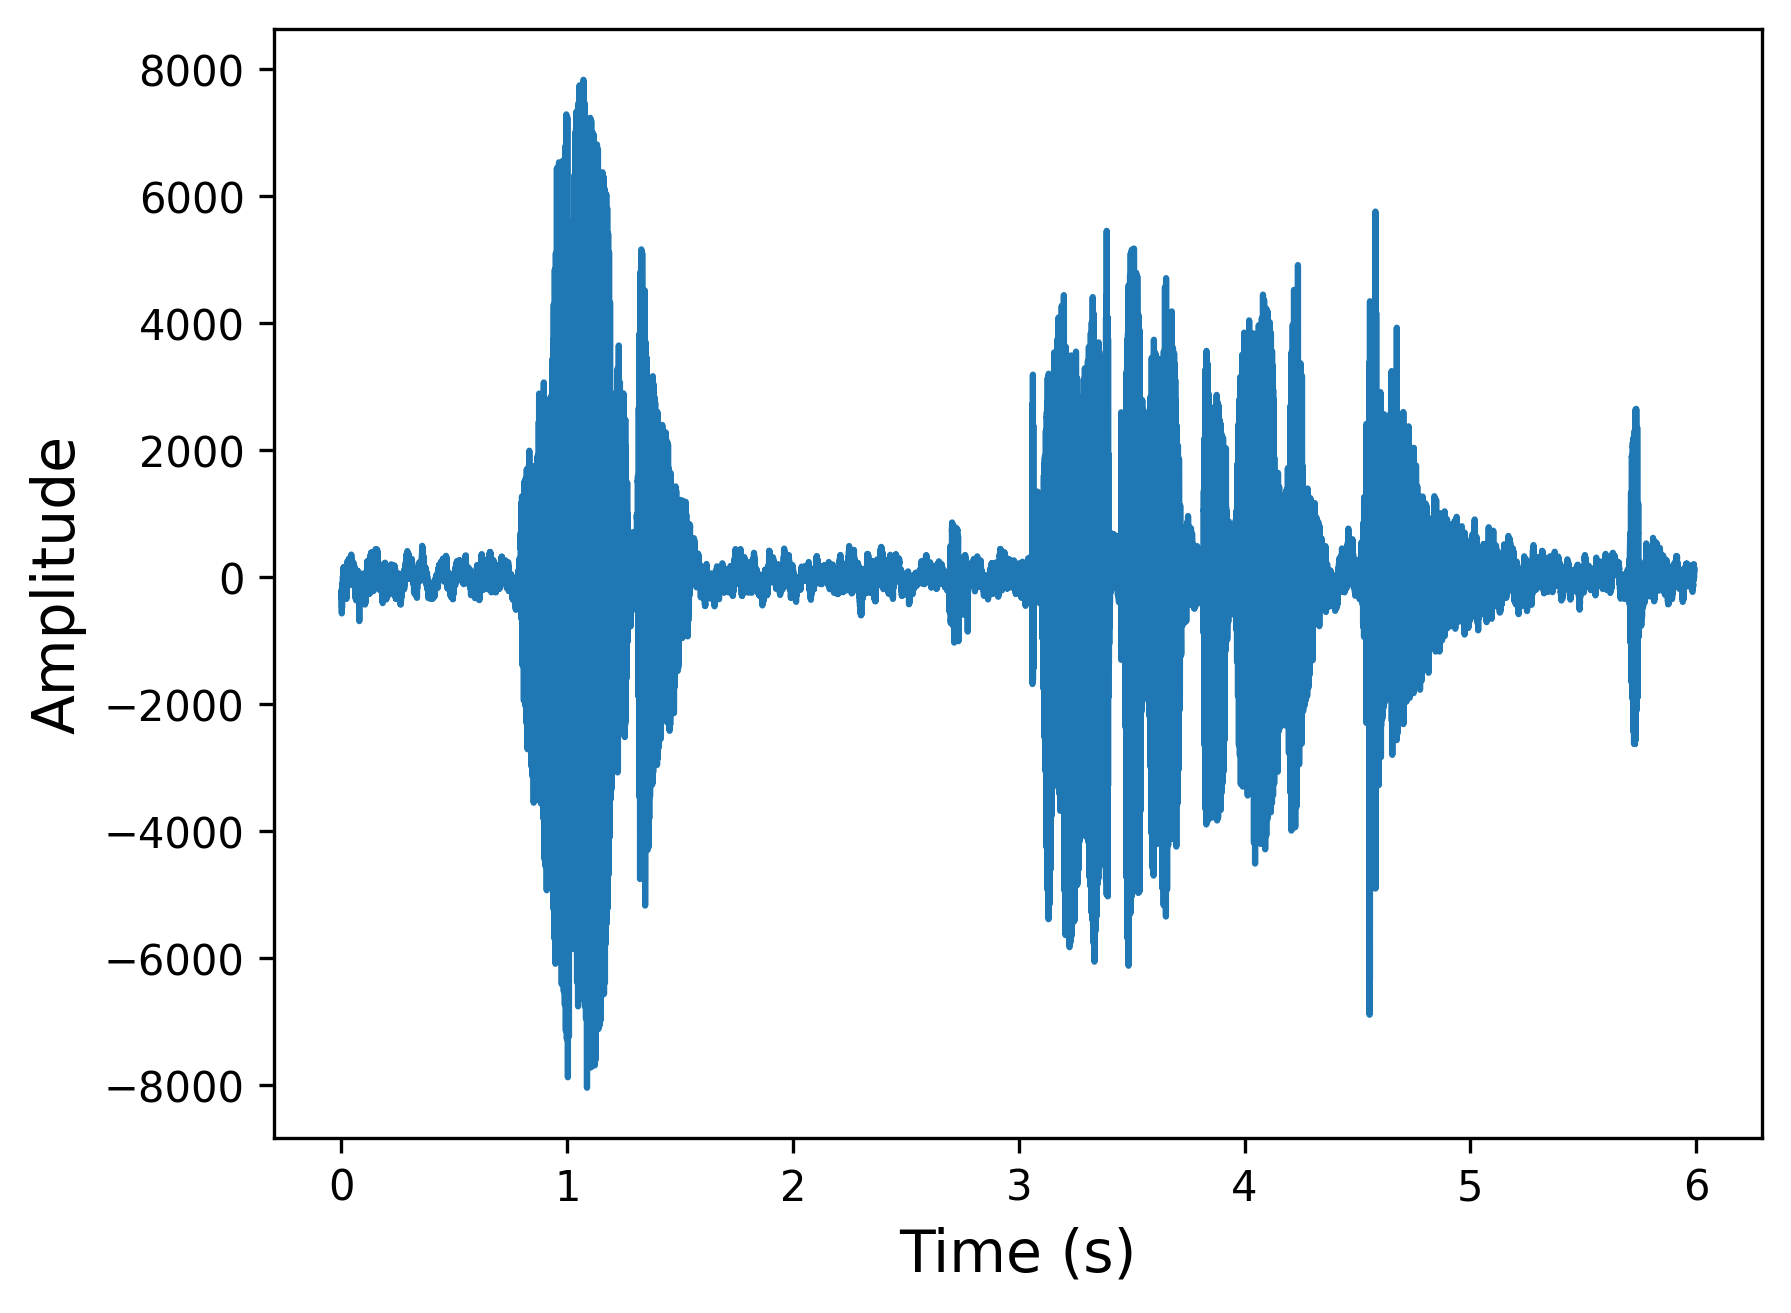

In [14]:
raw = wave.open("../Conversations/USER_08_CB2_Conversations/USER_08_CB2_20230202_123706/Audios/Subject_USER_08_CB2_T=11.wav")
signal = raw.readframes(-1)
signal = np.frombuffer(signal, dtype ="int16")
f_rate = raw.getframerate()
time = np.linspace(0, len(signal) / f_rate, num = len(signal))

plt.figure(dpi=300)

# actual plotting
plt.plot(time, signal,c="tab:blue")
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Amplitude", fontsize=14)

plt.savefig("Results/HUMANAUDIO.pdf", dpi=300, format="pdf", bbox_inches='tight')

# shows the plot
# in new window
# plt.show()